In [1]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from datasets import load_dataset, DatasetDict, Dataset, load_metric
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer,AutoConfig
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from sklearn.model_selection import train_test_split
from pathlib import Path
import time
import pandas as pd

from transformers import Trainer, AutoFeatureExtractor
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [2]:
# PyT_ViT
# https://stackoverflow.com/questions/64947064/transformers-pretrained-model-with-dropout-setting

In [3]:

# Define the path to your image directory
version = 'ViT_050_07'

image_directory = '/lustre/home/forozco/HKM/Github/WatChMaL/HK_ViT/data/100e/2D_black'
output_directory = f'/lustre/home/forozco/HKM/Github/WatChMaL/HK_ViT/output/{version}'

# Parameters
image_size = (224, 224)  # Target size for resizing the images
numero_epocas = 5
tasa_aprendizaje = 2e-5
batch_size_train = 10   # Default 10
batch_size_val = 4      # Default 4
w_decay = 0.01
hidden_dropout = .1
probs_dropout = .1


In [4]:
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

In [5]:
# Helper function to load images and labels
def load_images_from_directory(directory):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Assuming directories are named by class
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(class_indices[class_name])
    
    return image_paths, labels, class_names


def load_resize_convert_image(image_path, size):
    with Image.open(image_path) as img:
        #img = img.convert("RGB")  # Ensure the image is in RGB format
        img = img.resize(size)    # Resize the image
        #return (np.array(img) / 127.5) -1  # Normalizado entre rangos -1 a 1
        #return np.array(img) / 255.0       # Normalizado entre rangos 0 a 1
        return np.array(img)      # Convert to numpy array

# Load image paths and labels
image_paths, labels, class_names = load_images_from_directory(image_directory)


##################################
###################################

#labels, class_names


In [6]:
# Convert to a Dataset object
# Create a Dataset object with paths and labels
data = {'image_path': image_paths, 'label': labels}
dataset = Dataset.from_dict(data)


In [7]:
# Function to process the images and convert them to RGB format
def process_images(example):
    example['image'] = load_resize_convert_image(example['image_path'], image_size)
    return example


In [8]:
# Apply the processing function to load and convert images to RGB format
dataset = dataset.map(process_images, batched=False)

# Split the data into training (80%), validation (10%), and testing (10%) sets
splits = dataset.train_test_split(test_size=0.2)

trainds = splits['train']
splits_2 = splits['test'].train_test_split(test_size=0.5)
valds = splits_2['train']
testds = splits_2['test']

trainds, valds, testds


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

(Dataset({
     features: ['image_path', 'label', 'image'],
     num_rows: 160
 }),
 Dataset({
     features: ['image_path', 'label', 'image'],
     num_rows: 20
 }),
 Dataset({
     features: ['image_path', 'label', 'image'],
     num_rows: 20
 }))

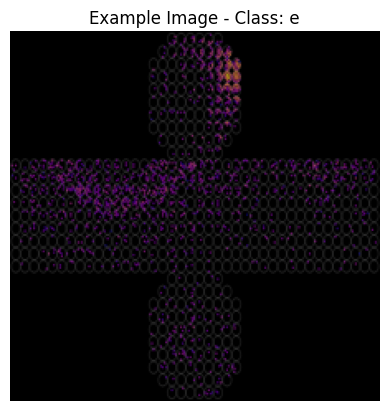

In [9]:
# Display an example image from the training set
def show_example_image(dataset_dict, class_names):
    # Select a random example from the training set
    example = dataset_dict.shuffle(seed=42).select([0])[0]
    
    # The image is already in RGB format as a numpy array
    img = example['image']
    

    # Display the image
    plt.imshow(img)
    plt.title(f'Example Image - Class: {class_names[example["label"]]}')
    plt.axis('off')  # Hide the axis
    plt.show()

# Display an example image from the training set
show_example_image(trainds, class_names)
                

Preprocesamiento de los datos:

In [10]:
itos = {0:'gamma', 1:'electron'}
stoi = {'gamma':0, 'electron':1}

itos

{0: 'gamma', 1: 'electron'}

In [11]:
# Antes de usar el Visual Transformer, necesitamos preprocesar las imágenes
# de entrada al formato en que fue entrenado este ViT: tamaño 224x224 y los
# canales RGB normalizados con media 0.5 y desviación estándar 0.5, cada canal.

model_name = "google/vit-base-patch16-224"
modelo_local = False

#model_name = "../output/ViT_009/modelo_ViT_009/"
#modelo_local = True

processor = ViTImageProcessor.from_pretrained(model_name, local_files_only=modelo_local)

mu, sigma = processor.image_mean, processor.image_std 
size = processor.size

In [12]:
mu, sigma, size

([0.5, 0.5, 0.5], [0.5, 0.5, 0.5], {'height': 224, 'width': 224})

In [13]:
# Ahora apliquemos las transformaciones para ajustar las imagenes al
# formato de entrada pedido por ViT:

norm = Normalize(mean=mu, std=sigma) # Función para normalizar los pixeles RGB en el rango [-1,1] aprox.
print (norm)
# Ajusta el tamaño 3x32x32 a 3x224x224, los convierte en un tensor del tipo PyTorch y aplicamos la normalización:
_transf = Compose([
    Resize(size['height']),
    ToTensor(),
    norm
])

# Transformamos cada PIL Image y la guardamos en el diccionario arg con la clave (key) 'pixels':
def transf(arg):
    arg['pixels'] = [_transf(Image.open(image_path).convert('RGB').resize(image_size)) for image_path in arg['image_path']]    
    return arg

Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


In [14]:
norm, _transf, transf

(Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
 Compose(
     Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 <function __main__.transf(arg)>)

In [15]:
# Apliquemos estas trasnformaciones a cada conjunto de datos:
trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

In [16]:
print(trainds[8]['pixels'][0].max(), trainds[8]['pixels'][0].min())
print(trainds[8]['pixels'][1].max(), trainds[8]['pixels'][1].min())
print(trainds[8]['pixels'][2].max(), trainds[8]['pixels'][2].min())

tensor(-0.5765) tensor(-1.)
tensor(-0.5765) tensor(-1.)
tensor(-0.5765) tensor(-1.)


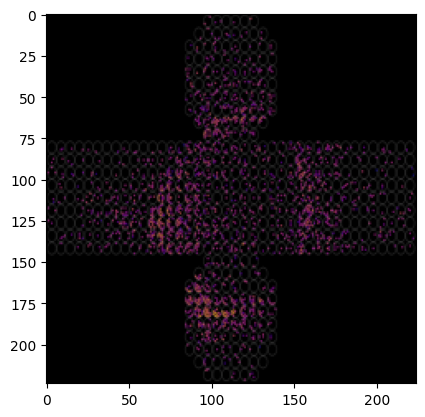

In [17]:
# Veamos cómo queda una imagen transformada:

idx = 14
ex = trainds[idx]['pixels']
ex = (ex+1)/2      # La función imshow requiere que los valores de pixeles estén en el rango [0,1].
exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

Fine-Tuning Model

In [18]:
# Como ya comentamos, usaremos el modelo ViT-Base, y vemos que su configuración
# predeterminada son Patches de entrada de tamaño 3x16x16=768 y la salida son
# las 1,000 clases de ImageNet:
#model_name = "google/vit-base-patch16-224"

model = ViTForImageClassification.from_pretrained(model_name, local_files_only=modelo_local)
print(model.config)
print('\n', model.classifier)

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "15": "robin, American robin, Turdus migratorius",
    "16": "bulbul",
 

In [19]:
# Ajustamos entonces el modelo a nuestros conjuntos de CIFAR-10:

model = ViTForImageClassification.from_pretrained(model_name,
                                                num_labels=2,
                                                ignore_mismatched_sizes=True,
                                                id2label=itos,
                                                label2id=stoi,
                                                hidden_dropout_prob = hidden_dropout,
                                                attention_probs_dropout_prob = probs_dropout
                                                )

print('\n', model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Linear(in_features=768, out_features=2, bias=True)


In [20]:
print('\n', model.config)


 ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "gamma",
    "1": "electron"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "electron": 1,
    "gamma": 0
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.44.2"
}



In [21]:
# Usaremos la clase Trainer para definir todos nuestros hiperparámetros
# del entrenamiento, por lo que vamos definiendo varios de los argumentos
# usuales que requerimos:

# save_strategy="epoch" or "steps"
args = TrainingArguments(f"{version}",
                        save_strategy="steps",   
                        eval_strategy="steps",
                        logging_strategy="steps",
                        learning_rate=tasa_aprendizaje,
                        per_device_train_batch_size=batch_size_train,   
                        per_device_eval_batch_size=batch_size_val,     
                        num_train_epochs=1,
                        weight_decay=w_decay,    # factor que aplica a todos lo pesos de las capas (layers), menos bias y normalización, en Adam-optimizer.
                        load_best_model_at_end=True,
                        metric_for_best_model="accuracy",
                        logging_dir='logs',     # string del directorio para guardar el modelo, pesos, logs, ...
                        remove_unused_columns=False,    # si deseas quitar las columnas que no se usan durante el proceso de forward, p.ej, que una image no tenga su etiqueta.
                        )



In [22]:
#####
#metric_accuracy = load_metric("accuracy")
#def compute_metrics(eval_pred):
#    logits, labels = eval_pred
#    predictions = np.argmax(logits, axis=-1)
#    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)['accuracy']
#    return {"accuracy": accuracy}

# La función collate (cotejar) nos transforma todos los arreglos de NumPy
# en tensores PyTorch:
def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}


# Y definimos la función para la métrica, que en este caso es el Accuracy,
# pero puedes usar otras, obviamente:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [23]:
# Finalmente conjuntamos todo:

trainer = Trainer(model,
                  args,   # hiperparámetros del modelo
                  train_dataset=trainds,     # Train set
                  eval_dataset=valds,        # Validation set
                  data_collator=collate_fn,  # Cotejamos los datos como tensores de Pytorch
                  compute_metrics=compute_metrics,   # Métrica de evaluación
                  tokenizer=processor,       # Función de preprocesamiento del modelo ViT
                  )

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [24]:

# Create log file path
log_file = Path(f"{output_directory}/epoch_metrics.csv")
log_file.touch(exist_ok=True)

# Labels, indices, and predictions path
label_file = Path(f"{output_directory}/labels.npy")
index_file = Path(f"{output_directory}/indices.npy")
prediction_file = Path(f"{output_directory}/predictions.npy")
#for epoch in range(1, int(args.num_train_epochs) + 1):

with open(log_file, "w") as f:
    f.write("Epoch,Accuracy,Val_Accuracy,Loss,Val_Loss\n")
    all_labels = []
    all_indices = []
    all_predictions = []
    all_probabilities = []

    for epoch in range(1, numero_epocas + 1):
        start_time = time.time()

        train_result = trainer.train()
        log_history = pd.DataFrame(trainer.state.log_history)
        print(f'log_history:  {log_history}')

        # Train the model
        train_metrics = trainer.evaluate(trainds)
        train_accuracy = train_metrics['eval_accuracy']
        train_loss = train_metrics['eval_loss']
        print(f'Entrenamiento: accuracy y perdida: {train_accuracy} - {train_loss}')

        # Evaluate on validation/test set
        eval_metrics = trainer.evaluate()
        val_accuracy = eval_metrics['eval_accuracy']
        val_loss = eval_metrics['eval_loss']

        # Time taken for the epoch
        epoch_time = time.time() - start_time

        # Logging the results
        log_str = f"{epoch},{train_accuracy:.4f},{val_accuracy:.4f},{train_loss:.4f},{val_loss:.4f}\n"
        print(log_str)
        f.write(log_str)

    # Save labels, indices, and predictions
    predictions = trainer.predict(testds)
    logits, labels, indices = predictions.predictions, predictions.label_ids, predictions.predictions
    print(f'logits: {logits}')
    preds = np.argmax(logits, axis=-1)

    #logits = torch.from_numpy(logits[:,0])
    #print(f'logits: {logits}')
    
    #probs = nn.functional.softmax(logits, dim=-1) 

    print(f'logits: {logits}')
    print(f'labels: {labels}')
    print(f'preds: {preds}')
    #print(f'probs: {probs}')

    # Save labels, indices, and predictions to .npy files
    all_labels.append(labels)
    all_indices.append(indices)
    all_predictions.append(preds)

    # Save arrays
    np.save(label_file, np.concatenate(all_labels))
    np.save(index_file, np.concatenate(all_indices))
    np.save(prediction_file, np.concatenate(all_predictions))



Step,Training Loss,Validation Loss


log_history:     train_runtime  train_samples_per_second  train_steps_per_second  \
0        66.8396                     2.394                   0.239   

     total_flos  train_loss  epoch  step  
0  1.239872e+16    0.655317    1.0    16  


Entrenamiento: accuracy y perdida: 0.7 - 0.6128630638122559
1,0.7000,0.8000,0.6129,0.5241



Step,Training Loss,Validation Loss


log_history:     train_runtime  train_samples_per_second  train_steps_per_second  \
0        66.3695                     2.411                   0.241   

     total_flos  train_loss  epoch  step  
0  1.239872e+16    0.487655    1.0    16  
Entrenamiento: accuracy y perdida: 0.76875 - 0.5014621019363403
2,0.7688,0.8000,0.5015,0.4599



Step,Training Loss,Validation Loss


log_history:     train_runtime  train_samples_per_second  train_steps_per_second  \
0        64.8313                     2.468                   0.247   

     total_flos  train_loss  epoch  step  
0  1.239872e+16    0.317819    1.0    16  
Entrenamiento: accuracy y perdida: 0.9 - 0.28983697295188904
3,0.9000,0.8500,0.2898,0.3695



Step,Training Loss,Validation Loss


log_history:     train_runtime  train_samples_per_second  train_steps_per_second  \
0        65.0828                     2.458                   0.246   

     total_flos  train_loss  epoch  step  
0  1.239872e+16    0.147628    1.0    16  
Entrenamiento: accuracy y perdida: 0.94375 - 0.21833595633506775
4,0.9437,0.8500,0.2183,0.3127



Step,Training Loss,Validation Loss


log_history:     train_runtime  train_samples_per_second  train_steps_per_second  \
0        65.6266                     2.438                   0.244   

     total_flos  train_loss  epoch  step  
0  1.239872e+16    0.111893    1.0    16  
Entrenamiento: accuracy y perdida: 0.925 - 0.22587153315544128
5,0.9250,0.8500,0.2259,0.4169

logits: [[ 1.9010175 -1.622531 ]
 [-1.7274209  2.6708367]
 [ 2.6719015 -2.741116 ]
 [ 2.809618  -2.3515162]
 [ 1.6336641 -1.7222962]
 [ 1.874566  -1.8846174]
 [-1.5194212  1.9998063]
 [ 2.4351416 -2.1613507]
 [-1.4347446  2.3730948]
 [ 0.7272645 -0.2898157]
 [ 2.7337074 -2.364121 ]
 [ 1.8866926 -1.6097268]
 [-1.189485   1.2616009]
 [ 2.4805994 -2.5790572]
 [ 2.4984426 -2.2871556]
 [ 2.4540918 -2.4337616]
 [ 2.3608496 -2.4160728]
 [-1.5981487  2.1906114]
 [ 2.4344642 -2.496656 ]
 [ 2.5971005 -2.2515385]]
logits: [[ 1.9010175 -1.622531 ]
 [-1.7274209  2.6708367]
 [ 2.6719015 -2.741116 ]
 [ 2.809618  -2.3515162]
 [ 1.6336641 -1.7222962]
 [ 1.874566  -1.8846174

# Revision del ROC   

logits.shappe: (20, 2)
logits: [[ 1.9010175 -1.622531 ]
 [-1.7274209  2.6708367]
 [ 2.6719015 -2.741116 ]
 [ 2.809618  -2.3515162]
 [ 1.6336641 -1.7222962]
 [ 1.874566  -1.8846174]
 [-1.5194212  1.9998063]
 [ 2.4351416 -2.1613507]
 [-1.4347446  2.3730948]
 [ 0.7272645 -0.2898157]
 [ 2.7337074 -2.364121 ]
 [ 1.8866926 -1.6097268]
 [-1.189485   1.2616009]
 [ 2.4805994 -2.5790572]
 [ 2.4984426 -2.2871556]
 [ 2.4540918 -2.4337616]
 [ 2.3608496 -2.4160728]
 [-1.5981487  2.1906114]
 [ 2.4344642 -2.496656 ]
 [ 2.5971005 -2.2515385]]
probs: [0.02864958 0.9878507  0.00443838 0.00570249 0.03370052 0.02277211
 0.9712299  0.00998642 0.9782859  0.2655965  0.0060729  0.02941428
 0.92064077 0.0063077  0.00828    0.00748119 0.00835154 0.97787684
 0.00716668 0.00777807]


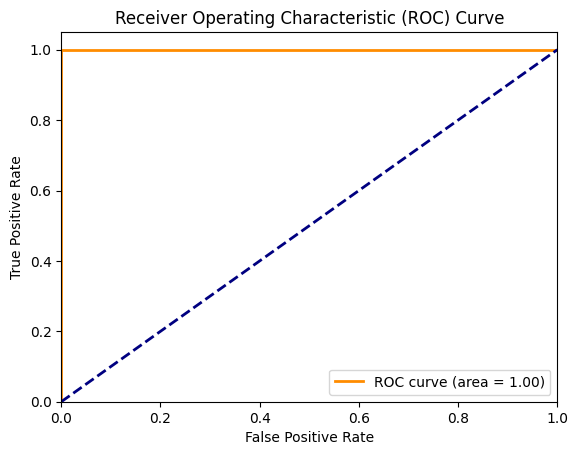

In [25]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Get probabilities for class 1
print(f'logits.shappe: {logits.shape}')
print(f'logits: {logits}')
probs = softmax(logits)[:, 1]  # Take the probability of class 1
print(f'probs: {probs}')

# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [26]:
logits.shape

(20, 2)

### Revision de resultados

In [27]:
print('resultados para el conjunto de Entrenamiento')

outputstrain = trainer.predict(trainds)
train_metrics = trainer.evaluate(trainds)
print(f'Metodo predict: {outputstrain.metrics}')
print(f'Metodo evaluate: {train_metrics}')

resultados para el conjunto de Entrenamiento


Metodo predict: {'test_loss': 0.22587153315544128, 'test_accuracy': 0.925, 'test_runtime': 47.2813, 'test_samples_per_second': 3.384, 'test_steps_per_second': 0.846}
Metodo evaluate: {'eval_loss': 0.22587153315544128, 'eval_accuracy': 0.925, 'eval_runtime': 47.7039, 'eval_samples_per_second': 3.354, 'eval_steps_per_second': 0.839, 'epoch': 1.0}


In [28]:

train_metrics = trainer.evaluate(valds)

In [29]:
train_metrics

{'eval_loss': 0.41688576340675354,
 'eval_accuracy': 0.85,
 'eval_runtime': 5.8717,
 'eval_samples_per_second': 3.406,
 'eval_steps_per_second': 0.852,
 'epoch': 1.0}

In [30]:
# Obtengamos ahora los resultados para el conjunto de Test:
print('resultados para el conjunto de Test')
outputs = trainer.predict(testds)
print(outputs.metrics)


resultados para el conjunto de Test
{'test_loss': 0.42673271894454956, 'test_accuracy': 0.85, 'test_runtime': 5.921, 'test_samples_per_second': 3.378, 'test_steps_per_second': 0.844}


In [31]:
# los de Validation:

print('resultados para el conjunto de Validacion')
outputsval = trainer.predict(valds)
print(outputsval.metrics)

resultados para el conjunto de Validacion


{'test_loss': 0.41688576340675354, 'test_accuracy': 0.85, 'test_runtime': 6.0485, 'test_samples_per_second': 3.307, 'test_steps_per_second': 0.827}


In [32]:
# los de Train:                      #  tarda como 11 mins sin GPU
print('resultados para el conjunto de Entrenamiento')

outputstrain = trainer.predict(trainds)
print(outputstrain.metrics)

resultados para el conjunto de Entrenamiento


{'test_loss': 0.22587153315544128, 'test_accuracy': 0.925, 'test_runtime': 54.98, 'test_samples_per_second': 2.91, 'test_steps_per_second': 0.728}


In [33]:
# Y la matriz de confusión con el conjunto de Test:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = ['gamma', 'electron']

In [34]:
labels

['gamma', 'electron']

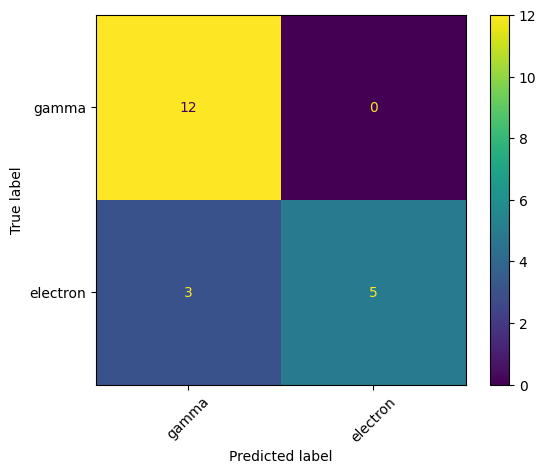

In [35]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

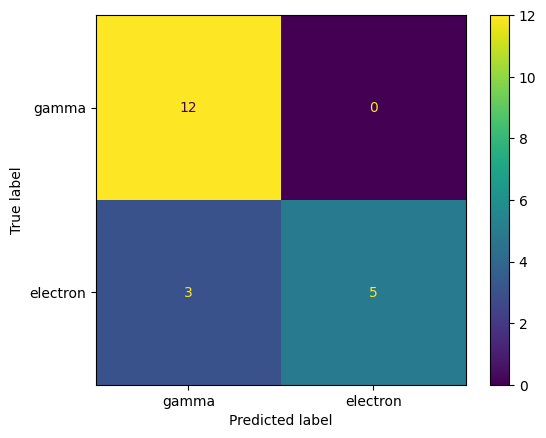

In [36]:
plt  = disp.plot().figure_
plt.savefig(f'{output_directory}/matriz_confusion')

# Guarda los LOGs de las pruebas

In [37]:
# Una vez que tengas el modelo adecuado, lo podemos guardar:
trainer.save_model(f'{output_directory}/modelo_{version}')

#trainer.save_pretrained(f'{output_directory}/pre_{version}')